## Embeddings: Motivation From Collaborative Filtering

Collaborative filtering is the task of making predictions about the interests of a user based on interests of many other users. As an example, let's look at the task of movie recommendation. Suppose we have 1,000,000 users, and a list of the movies each user has watched (from a catalog of 500,000 movies). Our goal is to recommend movies to users.

To solve this problem some method is needed to determine which movies are similar to each other. We can achieve this goal by embedding the movies into a low-dimensional space created such that similar movies are nearby.

Before describing how we can learn the embedding, we first explore the type of qualities we want the embedding to have, and how we will represent the training data for learning the embedding.

Arrange Movies on a One-Dimensional Number Line
To help develop intuition about embeddings, on a piece of paper, try to arrange the following movies on a one-dimensional number line so that the movies nearest each other are the most closely related:

Movie	Rating	Description
Bleu	R	A French widow grieves the loss of her husband and daughter after they perish in a car accident.
The Dark Knight Rises	PG-13	Batman endeavors to save Gotham City from nuclear annihilation in this sequel to The Dark Knight, set in the DC Comics universe.
Harry Potter and the Sorcerer's Stone	PG	A orphaned boy discovers he is a wizard and enrolls in Hogwarts School of Witchcraft and Wizardry, where he wages his first battle against the evil Lord Voldemort.
The Incredibles	PG	A family of superheroes forced to live as civilians in suburbia come out of retirement to save the superhero race from Syndrome and his killer robot.
Shrek	PG	A lovable ogre and his donkey sidekick set off on a mission to rescue Princess Fiona, who is emprisoned in her castle by a dragon.
Star Wars	PG	Luke Skywalker and Han Solo team up with two androids to rescue Princess Leia and save the galaxy.
The Triplets of Belleville	PG-13	When professional cycler Champion is kidnapped during the Tour de France, his grandmother and overweight dog journey overseas to rescue him, with the help of a trio of elderly jazz singers.
Memento	R	An amnesiac desperately seeks to solve his wife's murder by tattooing clues onto his body.

### Embeddings: Categorical Input Data

Categorical data refers to input features that represent one or more discrete items from a finite set of choices. For example, it can be the set of movies a user has watched, the set of words in a document, or the occupation of a person.

Categorical data is most efficiently represented via sparse tensors, which are tensors with very few non-zero elements. For example, if we're building a movie recommendation model, we can assign a unique ID to each possible movie, and then represent each user by a sparse tensor of the movies they have watched, as shown in Figure 3.

A sample input for our movie recommendation problem.

Figure 3. Data for our movie recommendation problem.

Each row of the matrix in Figure 3 is an example capturing a user's movie-viewing history, and is represented as a sparse tensor because each user only watches a small fraction of all possible movies. The last row corresponds to the sparse tensor [1, 3, 999999], using the vocabulary indices shown above the movie icons.

Likewise one can represent words, sentences, and documents as sparse vectors where each word in the vocabulary plays a role similar to the movies in our recommendation example.

In order to use such representations within a machine learning system, we need a way to represent each sparse vector as a vector of numbers so that semantically similar items (movies or words) have similar distances in the vector space. But how do you represent a word as a vector of numbers?

The simplest way is to define a giant input layer with a node for every word in your vocabulary, or at least a node for every word that appears in your data. If 500,000 unique words appear in your data, you could represent a word with a length 500,000 vector and assign each word to a slot in the vector.

If you assign "horse" to index 1247, then to feed "horse" into your network you might copy a 1 into the 1247th input node and 0s into all the rest. This sort of representation is called a one-hot encoding, because only one index has a non-zero value.

More typically your vector might contain counts of the words in a larger chunk of text. This is known as a "bag of words" representation. In a bag-of-words vector, several of the 500,000 nodes would have non-zero value.

But however you determine the non-zero values, one-node-per-word gives you very sparse input vectors—very large vectors with relatively few non-zero values. Sparse representations have a couple of problems that can make it hard for a model to learn effectively.

Size of Network
Huge input vectors mean a super-huge number of weights for a neural network. If there are M words in your vocabulary and N nodes in the first layer of the network above the input, you have MxN weights to train for that layer. A large number of weights causes further problems:

Amount of data. The more weights in your model, the more data you need to train effectively.

Amount of computation. The more weights, the more computation required to train and use the model. It's easy to exceed the capabilities of your hardware.

Lack of Meaningful Relations Between Vectors
If you feed the pixel values of RGB channels into an image classifier, it makes sense to talk about "close" values. Reddish blue is close to pure blue, both semantically and in terms of the geometric distance between vectors. But a vector with a 1 at index 1247 for "horse" is not any closer to a vector with a 1 at index 50,430 for "antelope" than it is to a vector with a 1 at index 238 for "television".

The Solution: Embeddings
The solution to these problems is to use embeddings, which translate large sparse vectors into a lower-dimensional space that preserves semantic relationships. We'll explore embeddings intuitively, conceptually, and programmatically in the following sections of this module.



### Embeddings: Translating to a Lower-Dimensional Space

You can solve the core problems of sparse input data by mapping your high-dimensional data into a lower-dimensional space.

As you can see from the paper exercises, even a small multi-dimensional space provides the freedom to group semantically similar items together and keep dissimilar items far apart. Position (distance and direction) in the vector space can encode semantics in a good embedding. For example, the following visualizations of real embeddings show geometrical relationships that capture semantic relations like the relation between a country and its capital:

Verb Tense
swimming
swam
walking
walked
Country-Capital
Canada
Ottawa
Turkey
Ankara
Russia
Moscow
Spain
Madrid
Italy
Rome
Germany
Berlin
Japan
Tokyo
Vietnam
Hanoi
China
Beijing
Male-Female
king
queen
man
woman
Figure 4. Embeddings can produce remarkable analogies.

This sort of meaningful space gives your machine learning system opportunities to detect patterns that may help with the learning task.

Shrinking the network
While we want enough dimensions to encode rich semantic relations, we also want an embedding space that is small enough to allow us to train our system more quickly. A useful embedding may be on the order of hundreds of dimensions. This is likely several orders of magnitude smaller than the size of your vocabulary for a natural language task.

Embeddings as lookup tables
An embedding is a matrix in which each column is the vector that corresponds to an item in your vocabulary. To get the dense vector for a single vocabulary item, you retrieve the column corresponding to that item.

But how would you translate a sparse bag of words vector? To get the dense vector for a sparse vector representing multiple vocabulary items (all the words in a sentence or paragraph, for example), you could retrieve the embedding for each individual item and then add them together.

If the sparse vector contains counts of the vocabulary items, you could multiply each embedding by the count of its corresponding item before adding it to the sum.

These operations may look familiar.

Embedding lookup as matrix multiplication
The lookup, multiplication, and addition procedure we've just described is equivalent to matrix multiplication. Given a 1 X N sparse representation S and an N X M embedding table E, the matrix multiplication S X E gives you the 1 X M dense vector.

But how do you get E in the first place? We'll take a look at how to obtain embeddings in the next section.


### Embeddings: Obtaining Embeddings

There are a number of ways to get an embedding, including a state-of-the-art algorithm created at Google.

Standard Dimensionality Reduction Techniques
There are many existing mathematical techniques for capturing the important structure of a high-dimensional space in a low dimensional space. In theory, any of these techniques could be used to create an embedding for a machine learning system.

For example, principal component analysis (PCA) has been used to create word embeddings. Given a set of instances like bag of words vectors, PCA tries to find highly correlated dimensions that can be collapsed into a single dimension.

Word2vec
Word2vec is an algorithm invented at Google for training word embeddings. Word2vec relies on the distributional hypothesis to map semantically similar words to geometrically close embedding vectors.

The distributional hypothesis states that words which often have the same neighboring words tend to be semantically similar. Both "dog" and "cat" frequently appear close to the word "vet", and this fact reflects their semantic similarity. As the linguist John Firth put it in 1957, "You shall know a word by the company it keeps".

Word2Vec exploits contextual information like this by training a neural net to distinguish actually co-occurring groups of words from randomly grouped words. The input layer takes a sparse representation of a target word together with one or more context words. This input connects to a single, smaller hidden layer.

In one version of the algorithm, the system makes a negative example by substituting a random noise word for the target word. Given the positive example "the plane flies", the system might swap in "jogging" to create the contrasting negative example "the jogging flies".

The other version of the algorithm creates negative examples by pairing the true target word with randomly chosen context words. So it might take the positive examples (the, plane), (flies, plane) and the negative examples (compiled, plane), (who, plane) and learn to identify which pairs actually appeared together in text.

The classifier is not the real goal for either version of the system, however. After the model has been trained, you have an embedding. You can use the weights connecting the input layer with the hidden layer to map sparse representations of words to smaller vectors. This embedding can be reused in other classifiers.

For more information about word2vec, see the tutorial on tensorflow.org

Training an Embedding as Part of a Larger Model
You can also learn an embedding as part of the neural network for your target task. This approach gets you an embedding well customized for your particular system, but may take longer than training the embedding separately.

In general, when you have sparse data (or dense data that you'd like to embed), you can create an embedding unit that is just a special type of hidden unit of size d. This embedding layer can be combined with any other features and hidden layers. As in any DNN, the final layer will be the loss that is being optimized. For example, let's say we're performing collaborative filtering, where the goal is to predict a user's interests from the interests of other users. We can model this as a supervised learning problem by randomly setting aside (or holding out) a small number of the movies that the user has watched as the positive labels, and then optimize a softmax loss.

3 DimensionalEmbedding
Sparse Vector Encoding
User Movies (subset used as input features)
...
...
User Movies(subset to use as "labels")
Target prob.dist (sparse) 
LogitLayer
0
1
2
3
4
5
6
7
8
9
Softmax Loss
Other features (optional)
...
...
Figure 5. A sample DNN architecture for learning movie embeddings from collaborative filtering data.

As another example if you want to create an embedding layer for the words in a real-estate ad as part of a DNN to predict housing prices then you'd optimize an L2 Loss using the known sale price of homes in your training data as the label.

When learning a d-dimensional embedding each item is mapped to a point in a d-dimensional space so that the similar items are nearby in this space. Figure 6 helps to illustrate the relationship between the weights learned in the embedding layer and the geometric view. The edge weights between an input node and the nodes in the d-dimensional embedding layer correspond to the coordinate values for each of the d axes.

Deep Network
Geometric view ofa single movieembedding  
Figure 6. A geometric view of the embedding layer weights.

# Intro to Sparse Data and Embeddings

**Learning Objectives:**
* Convert movie-review string data to a sparse feature vector
* Implement a sentiment-analysis linear model using a sparse feature vector
* Implement a sentiment-analysis DNN model using an embedding that projects data into two dimensions
* Visualize the embedding to see what the model has learned about the relationships between words

In this exercise, we'll explore sparse data and work with embeddings using text data from movie reviews (from the [ACL 2011 IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/)). This data has already been processed into `tf.Example` format.  

## Setup

Let's import our dependencies and download the training and test data. [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) includes a file download and caching tool that we can use to retrieve the data sets.

In [2]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

C:\Users\cfeng\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


40689664/40688441 [==============================] - 16s 0us/step


## Building a Sentiment Analysis Model

Let's train a sentiment-analysis model on this data that predicts if a review is generally *favorable* (label of 1) or *unfavorable* (label of 0).

To do so, we'll turn our string-value `terms` into feature vectors by using a *vocabulary*, a list of each term we expect to see in our data. For the purposes of this exercise, we've created a small vocabulary that focuses on a limited set of terms. Most of these terms were found to be strongly indicative of *favorable* or *unfavorable*, but some were just added because they're interesting.

Each term in the vocabulary is mapped to a coordinate in our feature vector. To convert the string-value `terms` for an example into this vector format, we encode such that each coordinate gets a value of 0 if the vocabulary term does not appear in the example string, and a value of 1 if it does. Terms in an example that don't appear in the vocabulary are thrown away.

**NOTE:** *We could of course use a larger vocabulary, and there are special tools for creating these. In addition, instead of just dropping terms that are not in the vocabulary, we can introduce a small number of OOV (out-of-vocabulary) buckets to which you can hash the terms not in the vocabulary. We can also use a __feature hashing__ approach that hashes each term, instead of creating an explicit vocabulary. This works well in practice, but loses interpretability, which is useful for this exercise. See see the tf.feature_column module for tools handling this.*

## Building the Input Pipeline

First, let's configure the input pipeline to import our data into a TensorFlow model. We can use the following function to parse the training and test data (which is in [TFRecord](https://www.tensorflow.org/programmers_guide/datasets) format) and return a dict of the features and the corresponding labels.

In [3]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
    Returns:
        A `tuple` `(labels, features)`:
        features: A dict of tensors representing the features
        labels: A tensor with the corresponding labels.
    """
    features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
    }
  
    parsed_features = tf.parse_single_example(record, features)
  
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']

    return  {'terms':terms}, labels

To confirm our function is working as expected, let's construct a `TFRecordDataset` for the training data, and map the data to features and labels using the function above.

In [4]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

Run the following cell to retrieve the first example from the training data set.

In [5]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

Now, let's build a formal input function that we can pass to the `train()` method of a TensorFlow Estimator object.

In [6]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
    # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(25, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)

  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Task 1: Use a Linear Model with Sparse Inputs and an Explicit Vocabulary

For our first model, we'll build a [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) model using 50 informative terms; always start simple!

The following code constructs the feature column for our terms. The [`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) function creates a feature column with the string-to-feature-vector mapping.

In [7]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

Next, we'll construct the `LinearClassifier`, train it on the training set, and evaluate it on the evaluation set. After you read through the code, run it and see how you do.

In [8]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78676
accuracy_baseline 0.5
auc 0.87189835
auc_precision_recall 0.86206686
average_loss 0.45258805
label/mean 0.5
loss 11.314701
precision 0.74556416
prediction/mean 0.5246366
recall 0.87064
global_step 1000
---
Test set metrics:
accuracy 0.78388
accuracy_baseline 0.5
auc 0.87034106
auc_precision_recall 0.86055887
average_loss 0.4527447
label/mean 0.5
loss 11.318617
precision 0.74389994
prediction/mean 0.5230902
recall 0.86584
global_step 1000
---


## Task 2: Use a Deep Neural Network (DNN) Model

The above model is a linear model.  It works quite well.  But can we do better with a DNN model?

Let's swap in a [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) for the `LinearClassifier`. Run the following cell, and see how you do.

In [10]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
    classifier.train(
        input_fn=lambda: _input_fn([train_path]),
        steps=1000)

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([train_path]),
        steps=1)
  
    print("Training set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([test_path]),
        steps=1)

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

except ValueError as err:
    print(err)

Training set metrics:
accuracy 0.88
accuracy_baseline 0.64
auc 0.9756943
auc_precision_recall 0.9862226
average_loss 0.31222126
label/mean 0.64
loss 7.8055315
precision 0.93333334
prediction/mean 0.54932815
recall 0.875
global_step 1000
---
Test set metrics:
accuracy 0.76
accuracy_baseline 0.56
auc 0.801948
auc_precision_recall 0.73465025
average_loss 0.5983784
label/mean 0.56
loss 14.95946
precision 0.78571427
prediction/mean 0.48745656
recall 0.78571427
global_step 1000
---


## Task 3: Use an Embedding with a DNN Model

In this task, we'll implement our DNN model using an embedding column. An embedding column takes sparse data as input and returns a lower-dimensional dense vector as output.

**NOTE:** *An embedding_column is usually the computationally most efficient option to use for training a model on sparse data. In an [optional section](#scrollTo=XDMlGgRfKSVz) at the end of this exercise, we'll discuss in more depth the implementational differences between using an `embedding_column` and an `indicator_column`, and the tradeoffs of selecting one over the other.*

In the following code, do the following:

* Define the feature columns for the model using an `embedding_column` that projects the data into 2 dimensions (see the [TF docs](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) for more details on the function signature for `embedding_column`).
* Define a `DNNClassifier` with the following specifications:
  * Two hidden layers of 20 units each
  * Adagrad optimization with a learning rate of 0.1
  * A `gradient_clip_norm` of 5.0

**NOTE:** *In practice, we might project to dimensions higher than 2, like 50 or 100.  But for now, 2 dimensions is easy to visualize.*


In [11]:
# Here's a example code snippet you might use to define the feature columns:

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

In [12]:
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78164
accuracy_baseline 0.5
auc 0.86754024
auc_precision_recall 0.8564398
average_loss 0.46199957
label/mean 0.5
loss 11.54999
precision 0.73801637
prediction/mean 0.53838044
recall 0.87328
global_step 1000
---
Test set metrics:
accuracy 0.78064
accuracy_baseline 0.5
auc 0.8671009
auc_precision_recall 0.8555911
average_loss 0.46221167
label/mean 0.5
loss 11.555292
precision 0.73883444
prediction/mean 0.53656006
recall 0.86816
global_step 1000
---


## Task 4: Convince yourself there's actually an embedding in there

The above model used an `embedding_column`, and it seemed to work, but this doesn't tell us much about what's going on internally. How can we check that the model is actually using an embedding inside?

To start, let's look at the tensors in the model:

In [13]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

Okay, we can see that there is an embedding layer in there: `'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`. (What's interesting here, by the way, is that this layer is trainable along with the rest of the model just as any hidden layer is.)

Is the embedding layer the correct shape? Run the following code to find out.

**NOTE:** *Remember, in our case, the embedding is a matrix that allows us to project a 50-dimensional vector down to 2 dimensions.*

In [14]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

Spend some time manually checking the various layers and shapes to make sure everything is connected the way you would expect it would be.

## Task 5: Examine the Embedding

Let's now take a look at the actual embedding space, and see where the terms end up in it. Do the following:
1. Run the following code to see the embedding we trained in **Task 3**. Do things end up where you'd expect?

2. Re-train the model by rerunning the code in **Task 3**, and then run the embedding visualization below again. What stays the same? What changes?

3. Finally, re-train the model again using only 10 steps (which will yield a terrible model). Run the embedding visualization below again. What do you see now, and why?

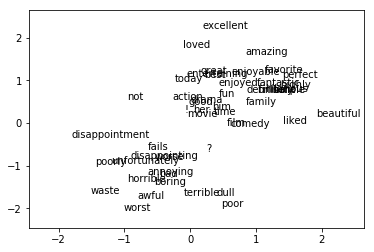

In [15]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    embedding_xy = np.matmul(term_vector, embedding_matrix)
    plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

## Task 6:  Try to improve the model's performance

See if you can refine the model to improve performance. A couple things you may want to try:

* **Changing hyperparameters**, or **using a different optimizer** like Adam (you may only gain one or two accuracy percentage points following these strategies).
* **Adding additional terms to `informative_terms`.** There's a full vocabulary file with all 30,716 terms for this data set that you can use at: https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt You can pick out additional terms from this vocabulary file, or use the whole thing via the `categorical_column_with_vocabulary_file` feature column.

In [16]:
# Download the vocabulary file.
terms_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

253952/253538 [==============================] - 0s 1us/step


In [17]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
    # Convert it to a set first to remove duplicates.
    informative_terms = list(set(f.read().split()))
  
    terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.82816
accuracy_baseline 0.5
auc 0.90348965
auc_precision_recall 0.90152365
average_loss 0.3940909
label/mean 0.5
loss 9.852272
precision 0.8269047
prediction/mean 0.49786946
recall 0.83008
global_step 1000
---
Test set metrics:
accuracy 0.81052
accuracy_baseline 0.5
auc 0.8898547
auc_precision_recall 0.88647914
average_loss 0.42048898
label/mean 0.5
loss 10.512224
precision 0.80842274
prediction/mean 0.49970144
recall 0.81392
global_step 1000
---


## A Final Word

We may have gotten a DNN solution with an embedding that was better than our original linear model, but the linear model was also pretty good and was quite a bit faster to train. Linear models train more quickly because they do not have nearly as many parameters to update or layers to backprop through.

In some applications, the speed of linear models may be a game changer, or linear models may be perfectly sufficient from a quality standpoint. In other areas, the additional model complexity and capacity provided by DNNs might be more important. When defining your model architecture, remember to explore your problem sufficiently so that you know which space you're in.


### *Optional Discussion:* Trade-offs between `embedding_column` and `indicator_column`

Conceptually when training a `LinearClassifier` or a `DNNClassifier`, there is an adapter needed to use a sparse column. TF provides two options: `embedding_column` or `indicator_column`.

When training a LinearClassifier (as in **Task 1**), an `embedding_column` in used under the hood. As seen in **Task 2**, when training a `DNNClassifier`, you must explicitly choose either `embedding_column` or `indicator_column`. This section discusses the distinction between the two, and the trade-offs of using one over the other, by looking at a simple example.

Suppose we have sparse data containing the values `"great"`, `"beautiful"`, `"excellent"`. Since the vocabulary size we're using here is $V = 50$, each unit (neuron) in the first layer will have 50 weights. We denote the number of terms in a sparse input using $s$. So for this example sparse data, $s = 3$. For an input layer with $V$ possible values, a hidden layer with $d$ units needs to do a vector-matrix multiply: $(1 \times V) * (V \times d)$.  This has $O(V * d)$ computational cost. Note that this cost is proportional to the number of weights in that hidden layer and independent of $s$.

If the inputs are one-hot encoded (a Boolean vector of length $V$ with a 1 for the terms present and a 0 for the rest) using an [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column), this means multiplying and adding a lot of zeros.

When we achieve the exact same results by using an [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) of size $d$, we look up and add up just the embeddings corresponding to the three features present in our example input of "`great`", "`beautiful`", "`excellent`": $(1 \times d) + (1 \times d) + (1 \times d)$. Since the weights for the features that are absent are multiplied by zero in the vector-matrix multiply, they do not contribute to the result. Weights for the features that are present are multiplied by 1 in the vector-matrix multiply. Thus, adding the weights obtained via the embedding lookup will lead to the same result as in the vector-matrix-multiply.

When using an embedding, computing the embedding lookup is an $O(s * d)$ computation, which is computationally much more efficient than the $O(V * d)$ cost for the `indicator_column` in sparse data for which $s$ is much smaller than $V$. (Remember, these embeddings are being learned. In any given training iteration it is the current weights that are being looked up.)


As we saw in **Task 3**, by using an `embedding_column` in training the `DNNClassifier`, our model learns a low-dimensional representation for the features, where the dot product defines a similarity metric tailored to the desired task. In this example, terms that are used similarly in the context of movie reviews (e.g., `"great"` and `"excellent"`) will be closer to each other the embedding space (i.e., have a large dot product), and terms that are dissimilar (e.g., `"great"` and `"bad"`) will be farther away from each other in the embedding space (i.e., have a small dot product).





